In [1]:
import sys

sys.path.append("..")

%load_ext autoreload
%autoreload complete

In [2]:
from math import ceil
from functools import partial
from pathlib import Path
import datetime

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import xarray as xr
import dask
import cftime

from lmrecon.io import IntakeESMLoader, save_mfdataset, open_mfdataset
from lmrecon.plotting import plot_field, subplots_cartopy, get_field_shorthand_label
from lmrecon.util import (
    stack_state,
    unstack_state,
    is_dask_array,
    get_data_path,
    to_math_order,
)
from lmrecon.eof import EOF, EOFMethod
from lmrecon.mapper import PhysicalSpaceForecastSpaceMapper
from lmrecon.logger import logging_disabled
from lmrecon.stats import area_weighted_mean, rmse

In [14]:
# ds = xr.open_zarr(get_data_path() / "cmip6/MRI-ESM2-0/past1000/seasonal_anomalies.zarr")[["tas", "tos", "siconc"]]
ds = xr.open_zarr(get_data_path() / "cmip6/MPI-ESM1-2-LR/past2k/seasonal_anomalies.zarr")[["tas", "ohc300", "ohc700"]]
# ds2 = ds.isel(time=slice(-100, None))
ds = ds.isel(time=slice(0, 1000))
ds

<xarray.Dataset> Size: 194MB
Dimensions:  (time: 1000, lat: 90, lon: 180)
Coordinates:
  * lat      (lat) float64 720B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float64 1kB 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time     (time) float64 8kB 1.292 1.542 1.792 2.042 ... 250.5 250.8 251.0
Data variables:
    tas      (time, lat, lon) float32 65MB dask.array<chunksize=(200, 90, 180), meta=np.ndarray>
    ohc300   (time, lat, lon) float32 65MB dask.array<chunksize=(200, 90, 180), meta=np.ndarray>
    ohc700   (time, lat, lon) float32 65MB dask.array<chunksize=(200, 90, 180), meta=np.ndarray>

In [15]:
data = to_math_order(stack_state(ds))
data

<xarray.DataArray '' (state: 48600, time: 1000)> Size: 194MB
dask.array<transpose, shape=(48600, 1000), dtype=float32, chunksize=(16200, 200), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 8kB 1.292 1.542 1.792 2.042 ... 250.5 250.8 251.0
  * state    (state) object 389kB MultiIndex
  * field    (state) <U6 1MB 'tas' 'tas' 'tas' ... 'ohc700' 'ohc700' 'ohc700'
  * lat      (state) float64 389kB -89.0 -89.0 -89.0 -89.0 ... 89.0 89.0 89.0
  * lon      (state) float64 389kB 0.0 2.0 4.0 6.0 ... 352.0 354.0 356.0 358.0

In [16]:
# mapper = PhysicalSpaceForecastSpaceMapper.load(Path('/home/enkf6/dstiller/lmrecon/reduced_space/2024-01-31T16-48-44/mapper.pkl'))
# datared = mapper.forward(data)
# datared

In [17]:
n_eofs = 15
mapper = PhysicalSpaceForecastSpaceMapper(n_eofs, 0, {f: n_eofs for f in ds.keys()}, separate_global_mean=True, standardize_by_season=False)
datared = mapper.fit_and_forward(data)#.compute()
datared

2025-01-06 17:07:17    INFO PhysicalSpaceForecastSpaceMapper.fit()
2025-01-06 17:07:17    INFO Calculating field variances
2025-01-06 17:07:18    INFO Splitting dataset into Dask arrays
2025-01-06 17:07:18    INFO Masking nans
2025-01-06 17:07:18    INFO Separating global mean for tas
2025-01-06 17:07:18    INFO Fitting EOF for tas [1/3]
2025-01-06 17:07:18   DEBUG Calculating EOFs using Dask (rank = 15)
2025-01-06 17:07:37    INFO Projecting EOF for tas
2025-01-06 17:07:37    INFO Separating global mean for ohc300
2025-01-06 17:07:37    INFO Fitting EOF for ohc300 [2/3]
2025-01-06 17:07:37   DEBUG Calculating EOFs using Dask (rank = 15)
2025-01-06 17:07:45    INFO Projecting EOF for ohc300
2025-01-06 17:07:45    INFO Separating global mean for ohc700
2025-01-06 17:07:45    INFO Fitting EOF for ohc700 [3/3]
2025-01-06 17:07:45   DEBUG Calculating EOFs using Dask (rank = 15)
2025-01-06 17:07:52    INFO Projecting EOF for ohc700
2025-01-06 17:07:52    INFO PhysicalSpaceForecastSpaceMappe

<xarray.DataArray 'rechunk-merge-105a07e50e69d942664e3308f0662492' (state: 48,
                                                                    time: 1000)> Size: 384kB
dask.array<rechunk-merge, shape=(48, 1000), dtype=float64, chunksize=(48, 1000), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 8kB 1.292 1.542 1.792 2.042 ... 250.5 250.8 251.0
  * state    (state) int64 384B 0 1 2 3 4 5 6 7 8 ... 39 40 41 42 43 44 45 46 47

(1.0, 15.0)

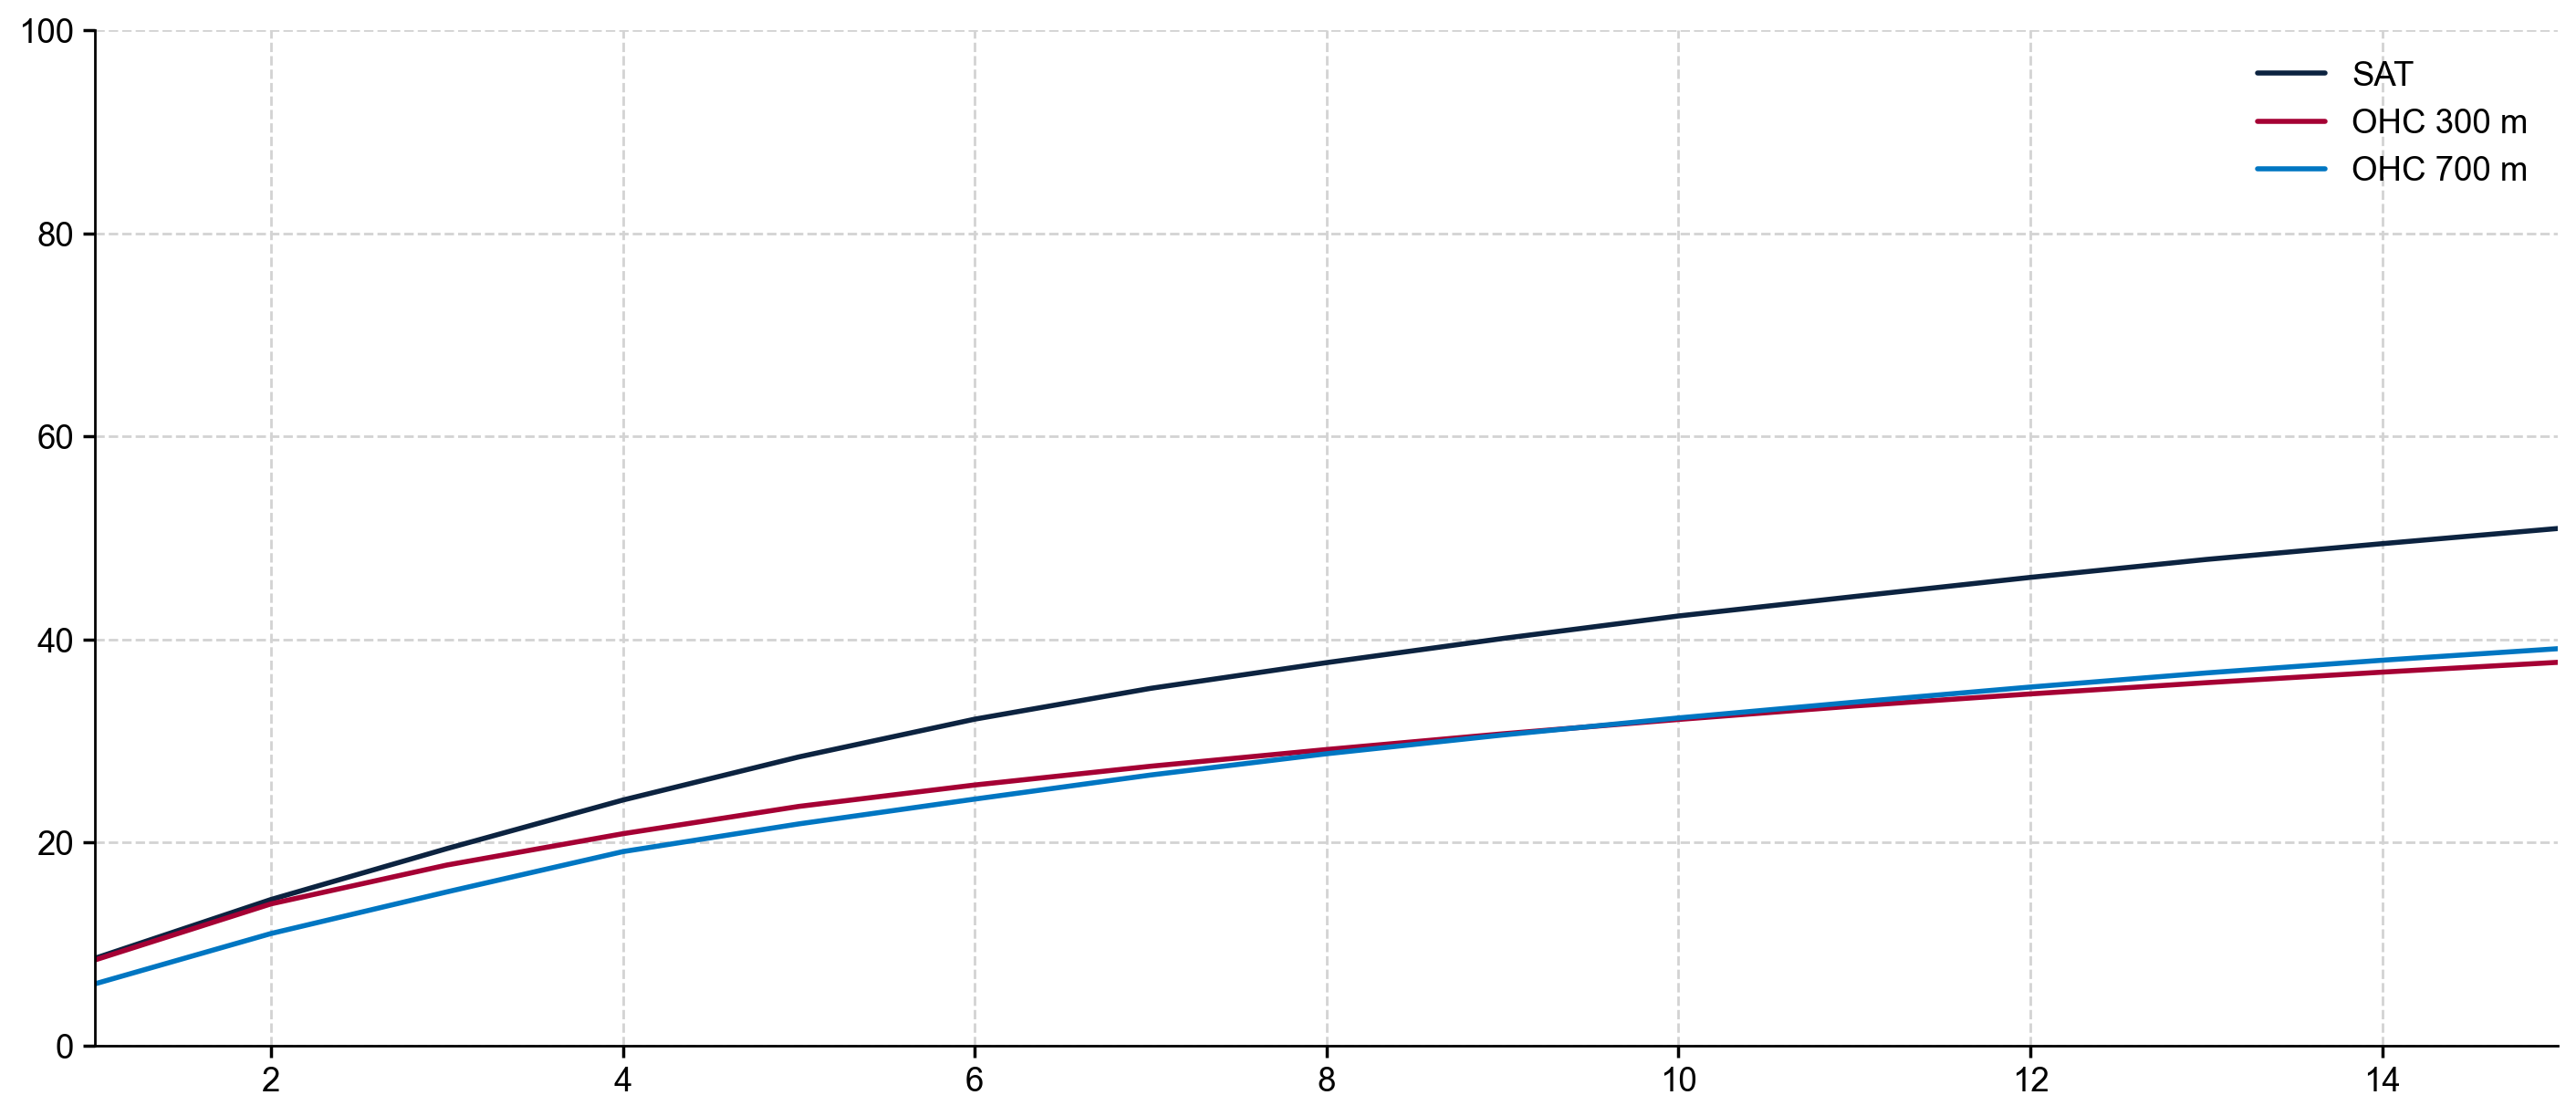

In [18]:
for f in ds.keys():
    plt.plot(np.arange(1, n_eofs+1), np.cumsum(mapper.eofs_individual[f].variance_fraction_per_mode) * 100, label=get_field_shorthand_label(f))
plt.legend()
plt.ylim(0, 100)
plt.xlim(1, n_eofs)

In [40]:
# mapper.save(Path("/home/enkf6/dstiller/enspred/mapper"))

Check linearity (RMSE should be zero):

In [41]:
rmse(
    mapper.forward(data * 50 + 100),
    mapper.forward(data) * 50 + mapper.forward(data.copy(data=100*dask.array.ones_like(data))),
).max().compute()

2025-01-02 19:33:14    INFO PhysicalSpaceForecastSpaceMapper.forward()
2025-01-02 19:33:14    INFO Splitting dataset into Dask arrays
2025-01-02 19:33:15    INFO Masking nans
2025-01-02 19:33:15    INFO Separating global mean for tas
2025-01-02 19:33:15    INFO Projecting EOF for tas [1/2]
2025-01-02 19:33:15    INFO Projecting EOF for tos [2/2]
2025-01-02 19:33:15    INFO Stacking direct fields for tas, tos
2025-01-02 19:33:15    INFO PhysicalSpaceForecastSpaceMapper.forward()
2025-01-02 19:33:15    INFO Splitting dataset into Dask arrays
2025-01-02 19:33:15    INFO Masking nans
2025-01-02 19:33:15    INFO Separating global mean for tas
2025-01-02 19:33:15    INFO Projecting EOF for tas [1/2]
2025-01-02 19:33:15    INFO Projecting EOF for tos [2/2]
2025-01-02 19:33:15    INFO Stacking direct fields for tas, tos
2025-01-02 19:33:15    INFO PhysicalSpaceForecastSpaceMapper.forward()
2025-01-02 19:33:15    INFO Splitting dataset into Dask arrays
2025-01-02 19:33:15    INFO Masking nans
2

<xarray.DataArray ()> Size: 8B
array(3.37700253e-09)

In [42]:
rmse(
    mapper.backward(datared * 50 + 100),
    mapper.backward(datared) * 50 + mapper.backward(datared.copy(data=100*dask.array.ones_like(datared))),
).max().compute()

2025-01-02 19:33:20    INFO PhysicalSpaceForecastSpaceMapper.backward()
2025-01-02 19:33:20    INFO PhysicalSpaceForecastSpaceMapper.backward()
2025-01-02 19:33:20    INFO PhysicalSpaceForecastSpaceMapper.backward()


<xarray.DataArray ()> Size: 8B
array(5.9226369e-13)

In [43]:
datarecon = mapper.backward(datared, force_stepwise=False)
dsrecon = unstack_state(datarecon).compute()
dsrecon

2025-01-02 19:33:25    INFO PhysicalSpaceForecastSpaceMapper.backward()


<xarray.Dataset> Size: 26MB
Dimensions:  (lat: 90, lon: 180, time: 100)
Coordinates:
  * lat      (lat) float64 720B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float64 1kB 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time     (time) float64 800B 850.3 850.5 850.8 851.0 ... 874.5 874.8 875.0
Data variables:
    tas      (time, lat, lon) float64 13MB -0.5093 -0.5276 ... 0.3884 0.389
    tos      (time, lat, lon) float64 13MB nan nan nan ... -0.01277 -0.01314

In [45]:
rmse(area_weighted_mean(dsrecon), area_weighted_mean(ds)).compute()

<xarray.Dataset> Size: 16B
Dimensions:  ()
Data variables:
    tas      float64 8B 4.701e-15
    tos      float64 8B 0.02198

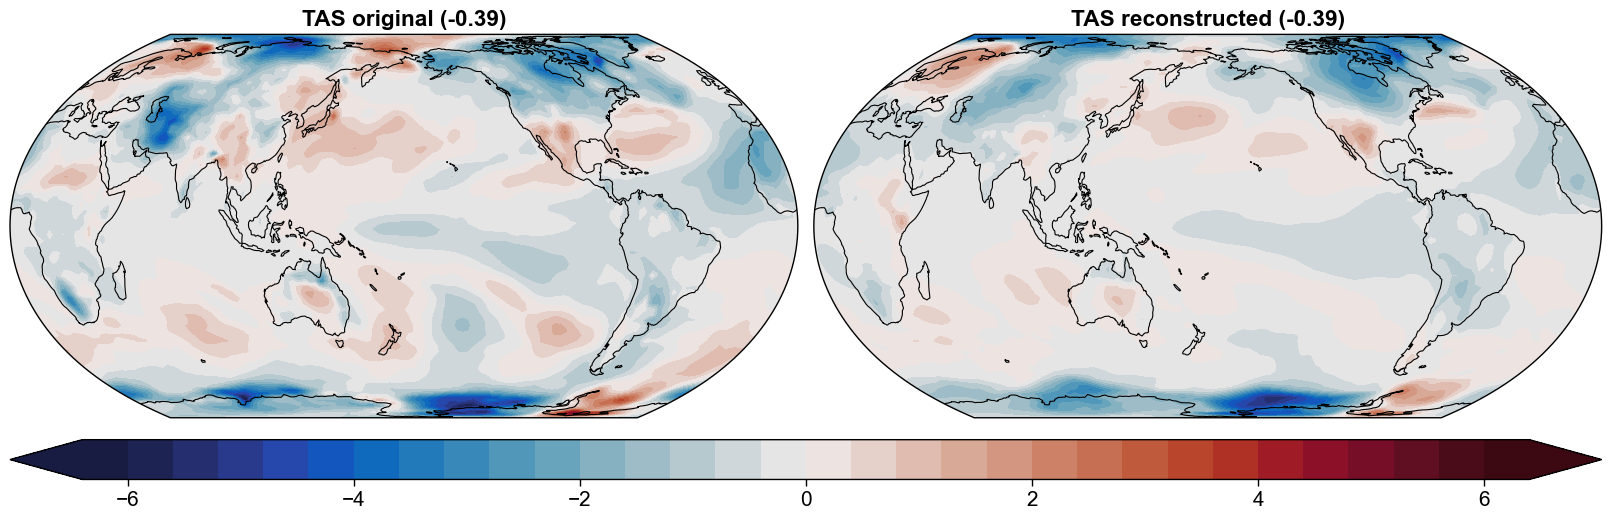

In [46]:
fig, axs = subplots_cartopy(1, 2, dpi=100)

field = "tas"
field_orig = ds.isel(time=0)[field]
field_recon = dsrecon.isel(time=0)[field]

mean_orig = area_weighted_mean(field_orig).compute().item()
mean_recon = area_weighted_mean(field_recon).compute().item()

axs[0].set_title(f"TAS original ({mean_orig:.2f})")
axs[1].set_title(f"TAS reconstructed ({mean_recon:.2f})")

plot_field(axs, [field_orig, field_recon], n_level=30)